Imports, env variables, and API key

In [13]:
import requests
import tmdbsimple as tmdb
import pandas as pd
from dotenv import load_dotenv
import os

# Loading environment variables and API key
load_dotenv()
API_KEY = os.getenv("TMDb_API_KEY")
if not API_KEY:
    raise ValueError("TMDB API Key not found. Make sure it's set in the .env file.")

tmdb.API_KEY = API_KEY
BASE_URL = "https://api.themoviedb.org/3"
WHOA_API_URL = "https://whoa.onrender.com/whoas/ordered/1-118"

Fetching TMDb Keanu movie credits

In [14]:
# Function to fetch movie credits from TMDb API
def fetch_tmdb_data():
    """
    Fetch Keanu Reeves's movie credits from the TMDb API
    and create a DataFrame with the required details.
    """
    url = f"{BASE_URL}/person/{6384}/movie_credits?api_key={API_KEY}"
    print(f"Requesting URL: {url}")
    response = requests.get(url)

    if response.status_code == 200:
        try:
            # Parsing JSON response
            movie_data = response.json()
            print("Request Successful!")

            # Extracting 'cast' information
            movies = movie_data.get('cast', [])

            # Creating a DataFrame with selected columns
            columns = ['movie_id', 'title', 'release_date', 'character', 'revenue']
            refined_movies = [
                {
                    'movie_id': movie.get('id'),  # Extract movie_id
                    'title': movie.get('title'),
                    'release_date': movie.get('release_date'),
                    'character': movie.get('character'),
                    'revenue': None  # Placeholder for now
                }
                for movie in movies
            ]

            tmdb_df = pd.DataFrame(refined_movies, columns=columns)
            print("TMDb DataFrame:")
            print(tmdb_df.head())
            return tmdb_df

        except requests.exceptions.JSONDecodeError:
            print("Error: Response could not be decoded as JSON")
            return pd.DataFrame()
    else:
        print(f"Error: {response.status_code} - {response.reason}")
        return pd.DataFrame()


Fetching "Whoa API" data

In [15]:
# Function to fetch "Whoa API" data
def fetch_whoa_data():
    headers = {"accept": "application/json"}
    response = requests.get(WHOA_API_URL, headers=headers)

    if response.status_code == 200:
        data = response.json()
        unique_movies = {movie['movie']: movie for movie in data}.values()
        df = pd.DataFrame(unique_movies)
        columns_to_keep = ['movie', 'year', 'release_date', 'character', 'total_whoas_in_movie']
        return df[columns_to_keep]
    else:
        print(f"Failed to fetch data from Whoa API. Status code: {response.status_code}")
        return pd.DataFrame()


Merging the data

In [16]:
# Function to merge TMDb and Whoa API data
def merge_data(tmdb_df, whoa_df):
    combined_df = pd.merge(
        whoa_df,
        tmdb_df,
        left_on=['movie'],
        right_on=['title'],
        how='left'
    )
    return combined_df

Fetching and updating the revenue "box office" information

In [17]:
# Function to fetch and update revenue information
def update_revenue_data(combined_df):
    revenues = []

    for index, row in combined_df.iterrows():
        movie_title = row['movie']
        movie_id = row.get('movie_id')

        if pd.isna(movie_title) or movie_id is None:
            revenues.append(None)
            print(f"Skipping movie: {movie_title} (No movie_id)")
            continue

        details_url = f"{BASE_URL}/movie/{movie_id}?api_key={API_KEY}"
        response = requests.get(details_url)

        if response.status_code == 200:
            movie_details = response.json()
            revenue = movie_details.get('revenue', None)
            revenues.append(revenue)
        else:
            print(f"Failed to fetch revenue for {movie_title} (ID: {movie_id})")
            revenues.append(None)
            
    combined_df['revenue'] = revenues
    return combined_df

Main execution

In [ ]:
if __name__ == "__main__":
    print("Fetching TMDb data...")
    tmdb_df = fetch_tmdb_data()

    print("Fetching Whoa API data...")
    whoa_df = fetch_whoa_data()

    if not tmdb_df.empty and not whoa_df.empty:
        print("Merging data...")
        combined_df = merge_data(tmdb_df, whoa_df)

        print("Updating revenue data...")
        combined_df = update_revenue_data(combined_df)

        output_file = "keanu_combined_data_with_revenue.csv"
        combined_df.to_csv(output_file, index=False)
        print(f"Combined data saved to {output_file}")
    else:
        print("Error: One or more data sources are empty. Aborting.")


Creating a Pandas pivot table

In [ ]:
# Creating the pivot table
pivot_table = combined_df.pivot_table(
    values = ['revenue', 'total_whoas_in_movie'],
    index = ['movie', 'year'],
    aggfunc = {'revenue': 'sum', 'total_whoas_in_movie': 'sum'}
)

# Sorting by year
pivot_table = pivot_table.sort_index(level = 'year')

# Formatting revenue as currency
pivot_table['revenue'] = pivot_table['revenue'].apply(lambda x: f"${x:,.0f}")

print(pivot_table)

Using matplotlib to visualize the data

C:\Users\Johnr\AppData\Local\Temp\ipykernel_9028\3796344408.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(pivot_table_reset['movie'], rotation=45, ha='right', fontsize=10)


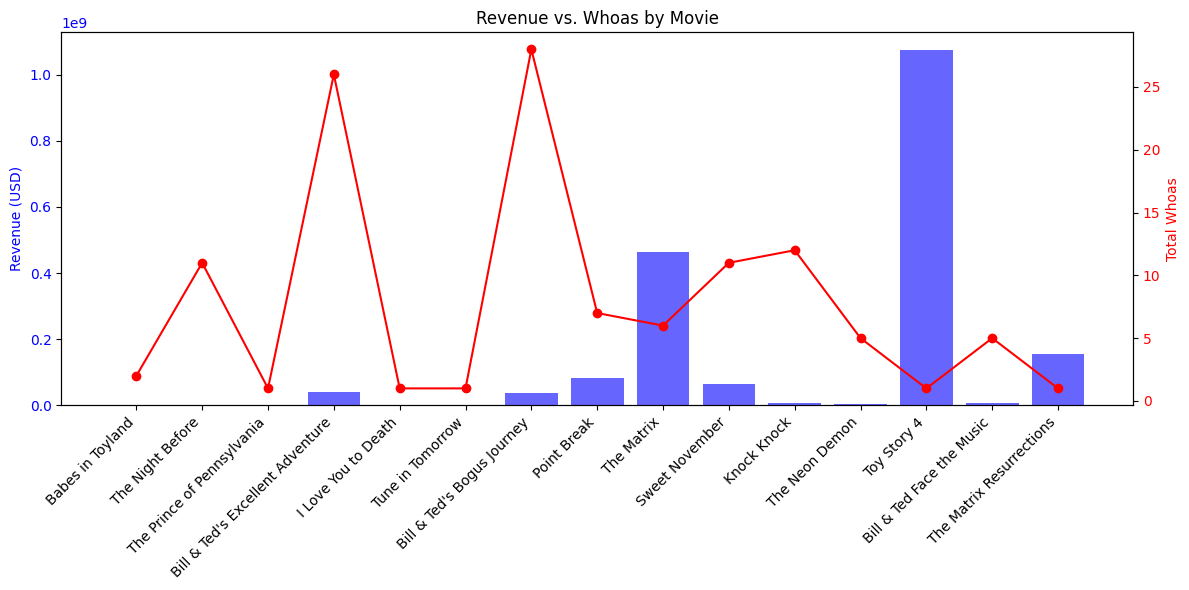

In [22]:
import matplotlib.pyplot as plt

# Reset index for easier plotting
pivot_table_reset = pivot_table.reset_index()

# Bar chart for revenue and whoas
fig, ax1 = plt.subplots(figsize=(12, 6))

# Revenue as bar chart
ax1.bar(pivot_table_reset['movie'], pivot_table_reset['revenue'].str.replace('[$,]', '', regex=True).astype(float), 
        color='blue', alpha=0.6, label='Revenue')
ax1.set_ylabel('Revenue (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Whoas as line plot
ax2 = ax1.twinx()
ax2.plot(pivot_table_reset['movie'], pivot_table_reset['total_whoas_in_movie'], 
         color='red', marker='o', label='Total Whoas')
ax2.set_ylabel('Total Whoas', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Formatting
plt.title('Revenue vs. Whoas by Movie')
ax1.set_xticklabels(pivot_table_reset['movie'], rotation=45, ha='right', fontsize=10)
fig.tight_layout()
plt.show()


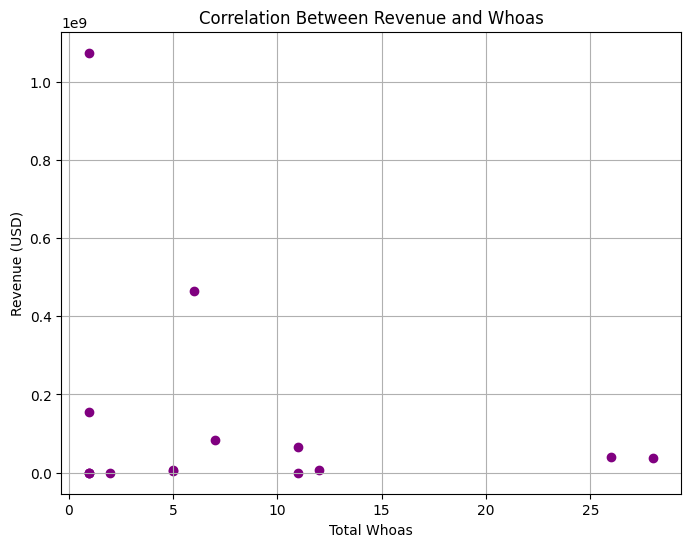

In [23]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    pivot_table_reset['total_whoas_in_movie'], 
    pivot_table_reset['revenue'].str.replace('[$,]', '', regex=True).astype(float), 
    color='purple'
)
plt.title('Correlation Between Revenue and Whoas')
plt.xlabel('Total Whoas')
plt.ylabel('Revenue (USD)')
plt.grid(True)
plt.show()
